# Multimodal
Combining images with facial action unit activations. 

In [1]:
name_of_this_notebook = 'multimodal_pretrained_potential.ipynb'

BATCH_SIZE = 32

experiment_name = f'multimodal-potential'


In [2]:
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2024-12-18 13:58:06.753633: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 13:58:06.774743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 13:58:06.774763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 13:58:06.775325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 13:58:06.778897: I tensorflow/core/platform/cpu_feature_guar

## Prepare Data

In [3]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/emoji-hero-multimodal/')

### Prepare FAU Data

In [4]:
import pandas as pd

fau_data_path = dataset_path / 'facial_action_unit_activations'

fau_test_df = pd.read_csv(str(fau_data_path / 'test_set.csv')).sort_values(by='timestamp').reset_index(drop=True)


def prepare_fau_data(df):
    X = df.iloc[:, 2:-1].values  # All columns except timestamp, participant_id, and label
    y = df.iloc[:, -1].values  # The last column is the label
    return X, y


fau_X_test, fau_y_test = prepare_fau_data(fau_test_df)

### Combine FAU with Image Data

Make sure that we have exactly two images (central and 45° side-view) for each FAU activations record. It is expected that there is not data for participant 7 (`<timestamp>-7-<camera-index>.jpg`). 

In [5]:
image_dataset_path = dataset_path / 'images'
image_test_set_path = image_dataset_path / 'test_set'


def load_image_paths(image_set_path, fau_df):
    print(f'\nLoading images from {image_set_path}...')
    image_paths = []
    labels = []
    fau_records = []
    perspectives = []
    for label_dir in image_set_path.iterdir():
        for img_file in label_dir.iterdir():
            timestamp = int(img_file.name.split('-')[0])
            perspective = int(img_file.name.split('-')[-1].split('.')[0])
            matching_fau = fau_df[fau_df['timestamp'] == timestamp]
            if not matching_fau.empty:
                image_paths.append(str(img_file))
                labels.append(int(label_dir.name))
                fau_records.append(matching_fau.iloc[0, 2:-1].values)
                perspectives.append(perspective)
            else:
                print(f'Could not find FAU data for image {img_file.name}')
    print(f'Found {len(image_paths)} images with corresponding fau data in {image_set_path}\n')
    return fau_records, image_paths, labels, perspectives


fau_test_records, image_test_paths, test_labels, test_perspectives = load_image_paths(image_test_set_path, fau_test_df)



Loading images from /home/thor/Desktop/datasets/emoji-hero-multimodal/images/test_set...
Found 756 images with corresponding fau data in /home/thor/Desktop/datasets/emoji-hero-multimodal/images/test_set



In [6]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)


def parse_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def load_combined_data(fau_records, image_paths, labels, perspectives, batch_size):
    fau_dataset = tf.data.Dataset.from_tensor_slices(fau_records)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    perspective_dataset = tf.data.Dataset.from_tensor_slices(perspectives)

    dataset = tf.data.Dataset.zip(((image_dataset, fau_dataset, perspective_dataset), label_dataset))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


test_dataset = load_combined_data(fau_test_records, image_test_paths, test_labels, test_perspectives, BATCH_SIZE)

2024-12-18 13:58:07.919411: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-18 13:58:07.939417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-18 13:58:07.939543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Compute Potential

### Load Pretrained Models

In [7]:
from tensorflow.keras.models import load_model

models_base_path = Path(r'/home/thor/Desktop/repos/emoji-hero-baseline')

img_model_path = models_base_path / '2_image' / 'emojihero_transfer_imagenet_20240320-1526' / 'best_model_phase_5.keras'
fau_model_path = models_base_path / '1_face_expressions' / '20241031-1748-checkpoint-batch-32-lr-1e-03_val_8155_test_7169' / 'fau_model.keras'

img_model = load_model(str(img_model_path))
fau_model = load_model(str(fau_model_path))

In [8]:
img_test_dataset = test_dataset.map(lambda inputs, labels: (inputs[0], labels))
img_loss, img_accuracy = img_model.evaluate(img_test_dataset)
print(f'Image Model - Test Loss: {img_loss}, Test Accuracy: {img_accuracy}')

2024-12-18 13:58:20.199584: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 13:58:20.419183: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-18 13:58:20.461053: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


24/24 [==============================] - 2s 27ms/step - loss: 1.5114 - accuracy: 0.6984
Image Model - Test Loss: 1.5113862752914429, Test Accuracy: 0.6984127163887024


In [9]:
fau_test_dataset = test_dataset.map(lambda inputs, labels: (inputs[1], labels))
fau_loss, fau_accuracy = fau_model.evaluate(fau_test_dataset)
print(f'FAU Model - Test Loss: {fau_loss}, Test Accuracy: {fau_accuracy}')

24/24 [==============================] - 0s 1ms/step - loss: 0.9676 - accuracy: 0.7169
FAU Model - Test Loss: 0.967613935470581, Test Accuracy: 0.7169312238693237


In [10]:
import numpy as np

fau_predictions = fau_model.predict(fau_test_dataset)
img_predictions = img_model.predict(img_test_dataset)

fau_pred_labels = np.argmax(fau_predictions, axis=1)
img_pred_labels = np.argmax(img_predictions, axis=1)

24/24 [==============================] - 1s 18ms/step


In [11]:
fau_correct = np.sum(fau_pred_labels == test_labels)
img_correct = np.sum(img_pred_labels == test_labels)

print(f'FAU Model - Correct Predictions: {fau_correct} out of {len(test_labels)}')
print(f'Image Model - Correct Predictions: {img_correct} out of {len(test_labels)}')

FAU Model - Correct Predictions: 542 out of 756
Image Model - Correct Predictions: 528 out of 756


In [12]:
case_counts = {
    'both_correct': np.zeros((7, 2)),
    'both_wrong': np.zeros((7, 2)),
    'image_correct_fau_wrong': np.zeros((7, 2)),
    'image_wrong_fau_correct': np.zeros((7, 2)),
}

for i in range(len(test_labels)):
    true_label = test_labels[i]
    img_pred = img_pred_labels[i]
    fau_pred = fau_pred_labels[i]
    perspective = int(test_perspectives[i])

    if img_pred == true_label and fau_pred == true_label:
        case_counts['both_correct'][true_label, perspective] += 1
    elif img_pred != true_label and fau_pred != true_label:
        case_counts['both_wrong'][true_label, perspective] += 1
    elif img_pred == true_label and fau_pred != true_label:
        case_counts['image_correct_fau_wrong'][true_label, perspective] += 1
    elif img_pred != true_label and fau_pred == true_label:
        case_counts['image_wrong_fau_correct'][true_label, perspective] += 1

In [13]:
import seaborn as sns

emotions = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger']
cases = ['both_correct', 'both_wrong', 'image_correct_fau_wrong', 'image_wrong_fau_correct']
colors = sns.color_palette("Blues", n_colors=len(cases))
perspective_labels = ['Central', 'Side']

## Save data

In [14]:
data = {
    'Emotion': [],
    'Perspective': [],
    'Case': [],
    'Count': []
}

emotions = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger']
cases = ['both_correct', 'image_correct_fau_wrong', 'image_wrong_fau_correct', 'both_wrong']
perspective_labels = ['Central', 'Side']

for i, emotion in enumerate(emotions):
    for j, perspective in enumerate(perspective_labels):
        for case in cases:
            count = case_counts[case][i, j]
            data['Emotion'].append(emotion)
            data['Perspective'].append(perspective)
            data['Case'].append(case)
            data['Count'].append(count)

df = pd.DataFrame(data)

csv_path = 'prediction_cases_data.csv'
df.to_csv(csv_path, index=False)
print(f'Data saved to {csv_path}')

Data saved to prediction_cases_data.csv


In [15]:
df.head(20)

,Emotion,Perspective,Case,Count
0,Neutral,Central,both_correct,32.0
1,Neutral,Central,image_correct_fau_wrong,6.0
2,Neutral,Central,image_wrong_fau_correct,13.0
3,Neutral,Central,both_wrong,3.0
4,Neutral,Side,both_correct,38.0
5,Neutral,Side,image_correct_fau_wrong,5.0
6,Neutral,Side,image_wrong_fau_correct,7.0
7,Neutral,Side,both_wrong,4.0
8,Happiness,Central,both_correct,45.0
9,Happiness,Central,image_correct_fau_wrong,1.0


In [16]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('prediction_cases_data.csv')
print(df.shape)
df.head()

(56, 4)


,Emotion,Perspective,Case,Count
0,Neutral,Central,both_correct,32.0
1,Neutral,Central,image_correct_fau_wrong,6.0
2,Neutral,Central,image_wrong_fau_correct,13.0
3,Neutral,Central,both_wrong,3.0
4,Neutral,Side,both_correct,38.0


In [17]:
df_pivoted = df.pivot_table(index=['Emotion', 'Perspective'], columns='Case', values='Count',
                            fill_value=0).reset_index()
df_pivoted.head()

csv_path = 'pivoted_prediction_cases_data.csv'
df_pivoted.to_csv(csv_path, index=False)
print(f'Data saved to {csv_path}')

Data saved to pivoted_prediction_cases_data.csv


In [18]:
emotions = ['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger']
cases = ['both_correct', 'both_wrong', 'image_correct_fau_wrong', 'image_wrong_fau_correct']
colors = sns.color_palette("Blues", n_colors=len(cases))
perspective_labels = ['Central', 'Side']

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# CSV-Datei laden
csv_path = 'prediction_cases_data.csv'
df = pd.read_csv(csv_path)

# DataFrame für das Diagramm vorbereiten und alphabetisch sortieren
emotions = sorted(['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger'])
cases = ['both_correct', 'image_wrong_fau_correct', 'image_correct_fau_wrong', 'both_wrong']

# Farbpalette definieren und Farben in der gewünschten Reihenfolge anpassen
colors = sns.color_palette('colorblind', n_colors=len(cases))
colors = [colors[2], colors[1], colors[0], colors[3]]  # Grün, helles Orange, Blau, dunkles Orange

# Summiere die Werte für beide Perspektiven
data_summed = df.groupby(['Emotion', 'Case']).sum().reset_index()

# Pivotiere das DataFrame, um es für das Plotting vorzubereiten und sortiere nach Emotionen
data_pivoted = data_summed.pivot(index='Emotion', columns='Case', values='Count').loc[emotions].fillna(0)

# Umbenennen der Labels
case_labels = {
    'both_correct': 'Both correct',
    'image_wrong_fau_correct': 'Only FEA correct',
    'image_correct_fau_wrong': 'Only Image correct',
    'both_wrong': 'Both wrong'
}

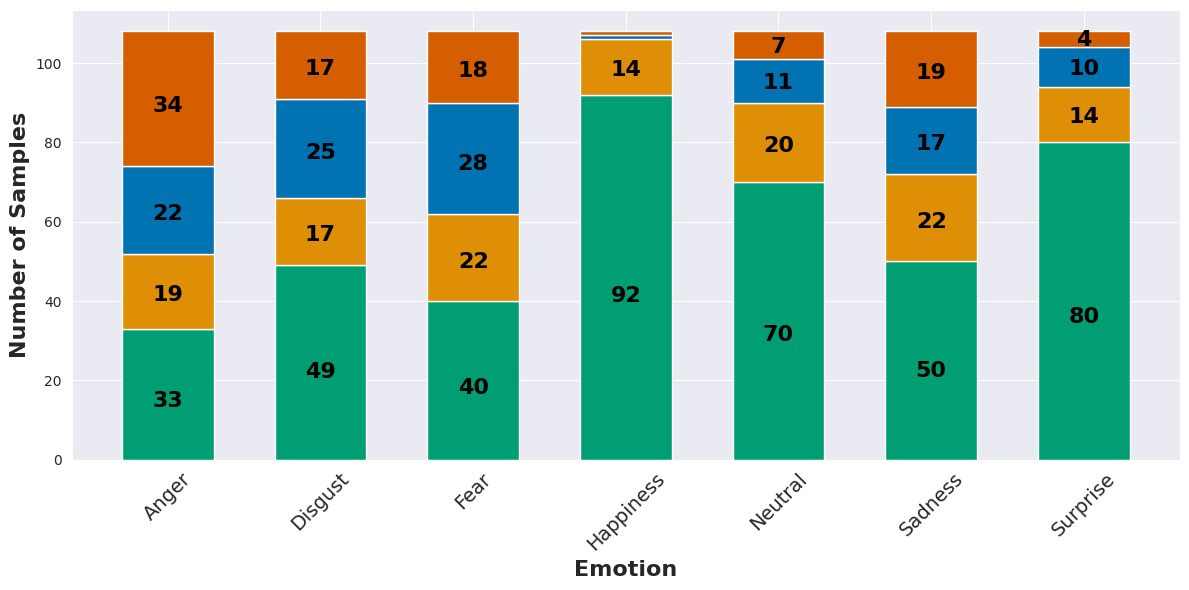

In [20]:
# Balkendiagramm erstellen
fig, ax = plt.subplots(figsize=(12, 6))

width = 0.6  # Breite der Balken
x = np.arange(len(emotions))

# Balkendiagramm erstellen
bottom = np.zeros(len(emotions))
for i, case in enumerate(cases):
    values = data_pivoted[case].values
    bars = ax.bar(x, values, width, bottom=bottom, label=case_labels[case], color=colors[i])
    bottom += values

    # Jeden Balken mit dem Wert annotieren
    for bar in bars:
        height = bar.get_height()
        if height > 1:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height*0.9 / 2, str(int(height)), ha='center',
                    va='center', fontsize=16, color='black', fontweight='bold')

# Beschriftungen und Titel
ax.set_xlabel('Emotion', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=16, fontweight='bold')
# ax.set_title('Distribution of Prediction Cases by Emotion', fontsize=14, fontweight='bold')

# x-Achsen-Beschriftungen anpassen
ax.set_xticks(x)
ax.set_xticklabels(emotions, fontsize=14)

# Legende anpassen
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, title='', fontsize=12, loc='upper right', bbox_to_anchor=(1.16, 1))

# x-Achsen-Beschriftungen
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('prediction_comparison.png', dpi=400)

plt.show()


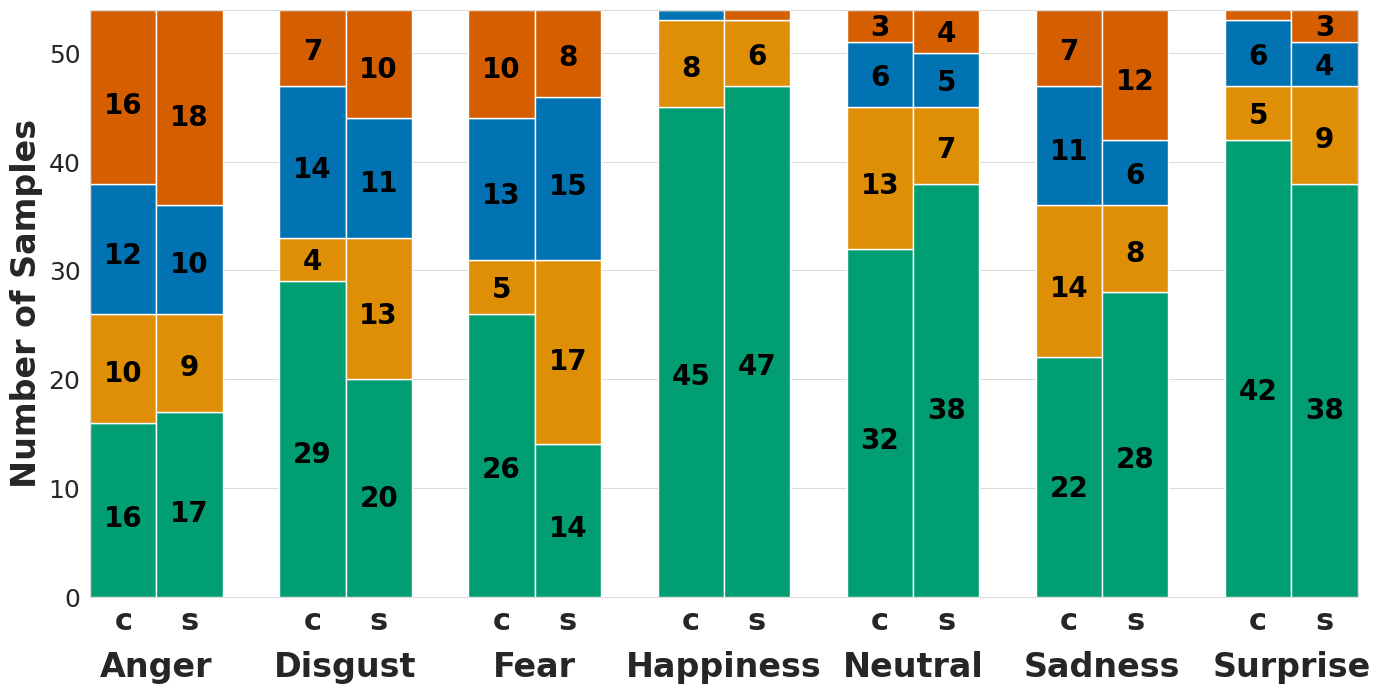

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

def plot_stacked_barchart(df):
    # DataFrame für das Diagramm vorbereiten und alphabetisch sortieren
    emotions = sorted(['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger'])
    cases = ['both_correct', 'image_wrong_fau_correct', 'image_correct_fau_wrong', 'both_wrong']
    perspective_labels = ['Central', 'Side']

    # Farbpalette definieren und Farben in der gewünschten Reihenfolge anpassen
    colors = sns.color_palette('colorblind', n_colors=len(cases))
    colors = [colors[2], colors[1], colors[0], colors[3]]  # Grün, helles Orange, Blau, dunkles Orange

    # Pivotiere das DataFrame, um es für das Plotting vorzubereiten und sortiere nach Emotionen
    data_pivoted = df.pivot_table(index=['Emotion', 'Perspective'], columns='Case', values='Count',
                                  fill_value=0).reset_index()
    data_pivoted = data_pivoted.set_index('Emotion').loc[emotions].reset_index()

    # Balkendiagramm erstellen
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.set_facecolor('white')  # Setze den Hintergrund auf weiß (anstatt des Standard-Graus)
    ax.grid(True, which='both', linestyle='-', linewidth=0.6, color='lightgray')  # Setze die Gitternetzlinien auf grau
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(True)  # Stelle sicher, dass die Spines sichtbar sind
        ax.spines[spine].set_color('lightgray')  # Setze die Farbe der Spines auf Grau
        ax.spines[spine].set_linewidth(0.6)

    width = 0.35  # Breite der Balken
    x = np.arange(len(emotions))

    # Balkendiagramm erstellen
    for j, perspective in enumerate(perspective_labels):
        bottom = np.zeros(len(emotions))
        for i, case in enumerate(cases):
            values = data_pivoted[data_pivoted['Perspective'] == perspective][case].values
            bars = ax.bar(x + (j - 0.5) * width, values, width, bottom=bottom,
                          label=case_labels[case] if j == 0 else None, color=colors[i])
            bottom += values

            # Jeden Balken mit dem Wert annotieren
            for bar in bars:
                height = bar.get_height()
                if height > 1:
                    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height * 0.9 / 2, str(int(height)), ha='center',
                            va='center', fontsize=20, color='black', fontweight='bold')

    # Beschriftungen und Titel
    ax.set_ylabel('Number of Samples', fontsize=24, fontweight='bold')
    # y-Achsen-Beschriftungen (Ticks) größer machen
    ax.tick_params(axis='y', labelsize=18)  # Schriftgröße der y-Ticks anpassen

    # x-Achsen-Beschriftungen anpassen
    xticks = []
    xticklabels = []
    for i, emotion in enumerate(emotions):
        xticks.append(x[i] - width / 2)
        xticks.append(x[i] + width / 2)
        xticklabels.append('c')
        xticklabels.append('s')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, fontsize=22, fontweight='bold')

    # Hinzufügen von Emotionen über den c/s Labels
    for i, emotion in enumerate(emotions):
        ax.text(x[i], -5, emotion, ha='center', va='top', fontsize=24, fontweight='bold')  # HIER ANGEPASST: Abstand zwischen Emotionen und c/s Labels verkleinert  # HIER ANGEPASST: Emotionen hinzugefügt

    # x-Achsen-Limits anpassen, damit die Balken direkt an den Rändern des Diagramms beginnen und enden
    ax.set_xlim(x[0] - width, x[-1] + width)

    # x-Achsen-Beschriftungen
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'prediction_comparison_central_and_side.png', dpi=400)
    plt.show()

# Beispielaufruf der Funktion
plot_stacked_barchart(df=pd.read_csv('prediction_cases_data.csv'))
